# RealNVP

Real-Valued Non-Volume Preserving Transformation- is the flow-based deep neural network, which is a tytpe of a probabilistic generative models that uses a sequence of invertible transformations to model complex data distributions. 

Some key characteristics are:
- Use bijective(invertible) functions, allowing efficien computation of forward of data to latent space and reverse transformation to data space. This means no information will be lost during the recovering from the latent space
- Use of Jacobian Determinant which is essential for handle dimensionality changes without losing data.

Applied areas:
- Density Estimation and Anomaly Detection. The exact likelihood computation makes it easier to identify anomalies
- Image and Vide generation
- Reversible data compression
- Data augmentation for cases when there are lack of original data
- Bayesian Inference and Probabillists modeling when uncertanty needs to be incorporated  
etc.

## INITIALIZATION

### Imports

In [30]:
from sklearn import datasets
from tensorflow.keras import (
    layers,
    regularizers,
    models,
    metrics,
    optimizers,
    callbacks,
    datasets
)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf
import datetime

### Functions

In [57]:
def display_img(images, n=10, fig_size=(20, 3), c_map='gray_r', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path = Path(save_to)
        
        oFull_path.parent.mkdir(parents=True, exist_ok=True)

    
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=fig_size)

    for i in range(n):
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    # Сохранение изображения
    if save_to:
        plt.savefig(save_to)

    plt.show()

def display_mnist_imgs(images, labels, n=5, show_random=False):
    '''
    Display images from MNIST dataset
    Args:
        images (ndarray): MNIST images
        labesls (ndarray): MNIST labels
        n (int): Number of images to display
        show_random (bool): Select images randonly or not

    Returns:
        Generates images from MNIST dataset in accrordance with given parameters
    '''
    
    if show_random:
        img_idx= np.random.choice(images.shape[0], n, replace=False)
    else:
        img_idx= range(0, n)

    plt.figure(figsize=(10,10))

    for i, idx in enumerate(img_idx):
        plt.subplot(2,n,i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')
    plt.show()

## KERAS MOONS

### Dataset generation

By using a scikit library generate a toy dataset with datapoints that forms two interleaving half circles

In [3]:
x, y = datasets.make_moons(30000, noise=5e-2)
x = x.astype('float32')
df = pd.DataFrame(x, columns=['x1', 'x2'])
df['label'] = y

### EDA

#### Original

In [4]:
df.shape

(30000, 3)

In [5]:
df.head()

x1        x2  label
0  0.742479  0.590819      0
1  0.157741 -0.122079      1
2 -0.010095  0.369025      1
3  1.548129 -0.294809      1
4 -0.080846  1.055402      0

In [6]:
df.describe().T

count      mean       std       min       25%       50%       75%  \
x1     30000.0  0.499926  0.867366 -1.155718 -0.042770  0.499408  1.043199   
x2     30000.0  0.250051  0.497081 -0.663515 -0.204547  0.250010  0.704150   
label  30000.0  0.500000  0.500008  0.000000  0.000000  0.500000  1.000000   

            max  
x1     2.140082  
x2     1.179036  
label  1.000000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      30000 non-null  float32
 1   x2      30000 non-null  float32
 2   label   30000 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 468.9 KB


In [8]:
df['label'].value_counts(normalize=True)

label
0    0.5
1    0.5
Name: proportion, dtype: float64

**INTERIM CONCLUSION**

We observe our dataset has been generated without missing data and in accordance with given parametrs. We see that our data is equally balanced and symetricly distributed.  

In a reson of that we see uneven distribution and scale factor between x1 and x2, as well as different centers it is recomended to normalize data

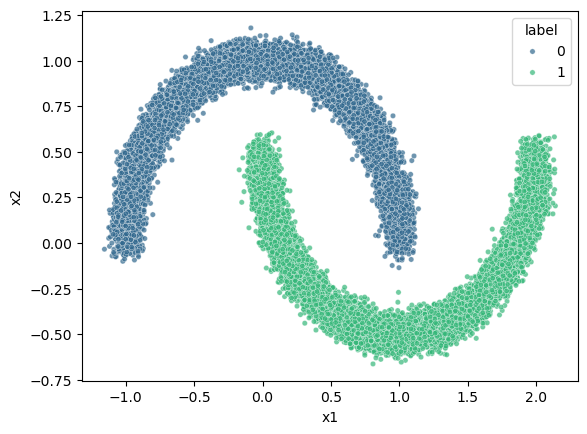

In [9]:
sns.scatterplot(
    data=df, 
    x='x1',
    y='x2',
    hue='label',
    palette='viridis',
    s=15,
    alpha=.7
);

**INTERIM CONCLUSION**

Visualization demonstrates how exactly generated data forms two half circles in the form of moons. Besides we alos see strong non-linear distribution

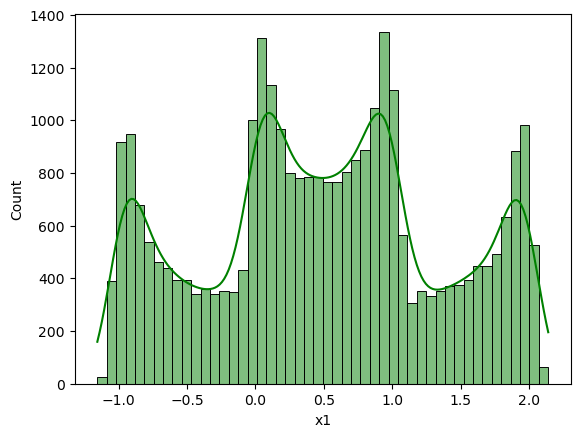

In [10]:
sns.histplot(
    df['x1'],
    kde=True,
    color='green'
);

**INTERIM CONCLUSION**

Here we observe multynidality, formed with four major peaks. 

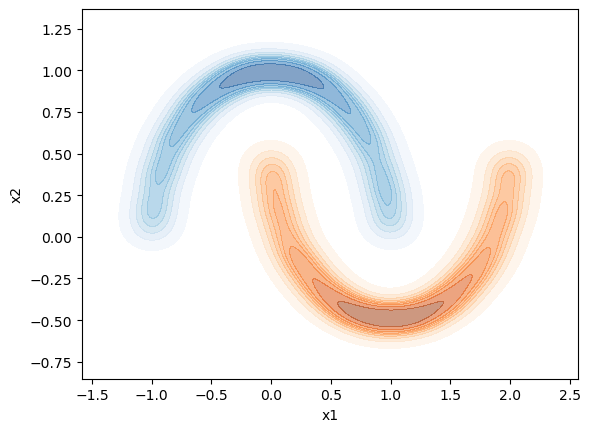

In [11]:
sns.kdeplot(
    data=df[df['label']==0],
    x='x1',
    y='x2',
    cmap='Blues',
    fill=True,
    alpha=.5,
    label='Class 0'
)
sns.kdeplot(
    data=df[df['label']==1],
    x='x1',
    y='x2',
    cmap='Oranges',
    fill=True,
    alpha=.5,
    label='Class 1'
);

**INTERIM CONCLUSION**

This viz demonstrates us a density distributions among 2 groups of data 0 and 1. We see that density distribution is even and symetrical

#### Normalization

In [12]:
norm = layers.Normalization()
norm.adapt(x)
x_norm = norm(x)


2024-11-10 13:46:30.536125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-10 13:46:30.769035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-10 13:46:30.769094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-10 13:46:30.781007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-10 13:46:30.781110: I external/local_xla/xla/stream_executor

In [13]:
norm_df = pd.DataFrame(x_norm, columns=['x1','x2'])
norm_df['label']=y

In [14]:
print('NORMALIZED DATA')
norm_df.describe().T

NORMALIZED DATA


count          mean       std       min       25%       50%  \
x1     30000.0 -2.271016e-07  1.000018 -1.908853 -0.625694 -0.000597   
x2     30000.0 -1.134745e-06  1.000016 -1.837893 -0.914553 -0.000084   
label  30000.0  5.000000e-01  0.500008  0.000000  0.000000  0.500000   

            75%       max  
x1     0.626359  1.890996  
x2     0.913545  1.868910  
label  1.000000  1.000000

In [15]:
print('RAW-GENERATED DATA')
df.describe().T

RAW-GENERATED DATA


count      mean       std       min       25%       50%       75%  \
x1     30000.0  0.499926  0.867366 -1.155718 -0.042770  0.499408  1.043199   
x2     30000.0  0.250051  0.497081 -0.663515 -0.204547  0.250010  0.704150   
label  30000.0  0.500000  0.500008  0.000000  0.000000  0.500000  1.000000   

            max  
x1     2.140082  
x2     1.179036  
label  1.000000

**INTERIM CONCLUSION**

We see that after normalization being done our data distribution now more densed around 1, standard deviation is tend to 1 and  mean for both groups are now tends to zero which is desired shape, besides that we now see our data are now evenly scaled.  
Now our data is well fit for machine learning algortyrhms

### BUILD RealNVP

<img src="./images/RealNVP-Schema.png" width="600" height="400">

**DESCRIPTION**  

  **X** - input data vector  
  
  **Flow f(x)** -  A series of invertible transforms that are composed together to make a more complex invertible transform. In other words this is a sequence of transformations through the Coupling layers, which transform the data flow into a new representation 𝑧. These transformations have a tractable likelihood, which is a key feature of this architecture. The purpose of the Coupling function is to enable the calculation of the Jacobian of the transformation, which is crucial for probability estimation.  
  
  **z** - The latent representation obtained after applying the Flow (i.e., 𝑓(𝑥)). In RealNVP, 𝑧 is modeled to follow a specified target distribution (e.g., a standard Gaussian distribution). The purpose of mapping 𝑥 to 𝑧 is to enable data manipulation in a space where probabilistic modeling is more straightforward.  
  
  **Inverse f^-1(z)** - The inverse transformation that is used to recover the transformed data from the latent space distribution back to the original data without any loss. It is important to note that in RealNVP, each transformation is bijective, meaning it is reversible. As a result, it is always possible to recover the original data 𝑥′ from 𝑧 using 𝑓^−1  
  
  **x'** - The reconstructed data, which should closely match the original input data 𝑥 after applying 𝑓^−1(𝑧). In RealNVP, the goal is for 
𝑥′ to be as similar to 𝑥 as possible, ensuring minimal loss in the data recovery process.

  **Normalizing** - The change of variable formula (Equation 5) gives us a normalized probability density.
  

#### Affine Coupling Layer
<img src="./images/ReealNVP-AffineTransformation.png" width="600" height="400">

Coupling layer is the key mechanism that allows to build a reversable data transformations
The main idea is to define a transform whose Jacobian forms a triangular matrix resulting in a very simple and efficient determinant computation.

The coupling layer is a simple scale and shift operation for some subset of the variables in the current layer, while the other half are used to compute the scale and shift. Given D dimensional input variables x, y  as the output of the block, and d < D

Coupling layers are only useful if we stack them (otherwise half of the variables would be unchanged). By using alternating patterns of spatial checkerboarding and channel wise masking with multiple coupling layers, we can ensure that the deep net touches every input variable and that it has enough capacity to learn the necessary invertible transform. This is directly analogous to adding layers in a feed forward network (albeit with more complexity in the loss function).

The number of latent(output) variables we use is equal to the input dimension of x! While models like VAEs or GANs usually have a much smaller latent representation, we're using many more variables. This makes perfect sense because our network is invertible so you need the same number of input and output dimensions but it seems inefficient! 

In [61]:
def Coupling_Moons(input_dim, coupling_dim, reg):
    '''
    The s-t(i.e. Scale-Translation(shift) factors) archtecture is needed in order to maintain reversable data flow transformations by calculating a Jacobian determinant.
    This is become achivable by transforming only half of variables leave the rest untouched
    The coupling layer masks the data as it flows
    through the network, in a way that ensures that the
    Jacobian is lower triangular and therefore has a simple-tocompute
    determinant. Full visibility of the input data is
    achieved through flipping the masks at each layer.

    Args
        input_dim (int): Input layer Dimensionality. Main purpose is identify input vector shape
        coupling_dim (int): Latent layers dimensionality.
        reg (float32): Regularization coefficient
    '''
    input_layer = layers.Input(shape=(input_dim,))

    # Skale component architecture
    # firtst 4 layers have relu activation which helps to learn non-linearity, as well as squize and scale data flow
    # tanh activation on last layer for stability purposes
    s_layer_1 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    s_layer_2 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)

    s_layer_3 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)

    s_layer_4 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)

    # We use a tanh activation multiplied by a learned scale parameter. This is presumably to mitigate 
    # the effect of using exp(s) to scale the variables. Directly using the outputs of a neural network could cause 
    # big swings in s leading to blowing up exp(s). 
    # To same point as above we also add a small L2 regularization on s
    s_layer_5 = layers.Dense(
        units=input_dim, # Note the number of output vars are equal to input
        activation='tanh',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    # Shift component architecture
    # relu activation uses for to learn non-linearity purposes
    # last layer uses linear activation as we need to shift our data flow with no restrictions
    t_layer_1 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    t_layer_2 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)

    t_layer_3 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)

    t_layer_4 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)

    t_layer_5 = layers.Dense(
        units=input_dim, # Note the number of output vars are equal to input
        activation='linear',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [62]:
class RealNVP(models.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()

        self.coupling_layers = coupling_layers
        # Configure a multivariate normal distribution with zero mean and unit variance.
        # This is used as the target distribution in the latent space, to which the model will map input data.
        self.distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])

        # Configure masks used to construct the coupling layers. Masks alternate between [0, 1] and [1, 0],
        # allowing some components to be transformed while others remain unchanged at each layer.
        self.masks = np.array([[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32")
        #self.masks = tf.tile(tf.constant([[0, 1], [1, 0]], dtype=tf.float32), [512 // 2, 1])

        # Set up a metric to track the average loss during training.
        self.loss_tracker = metrics.Mean(name='loss')

        # Initialize the list of coupling layers with the given input dimension, layer width, and regularization.
        self.layers_list = [Coupling_Moons(input_dim, coupling_dim, regularization) for i in range(coupling_layers)]

        self.input_dim=input_dim
       
       
    @property
    def metrics(self):
        return [self.loss_tracker]

   # This is X data which will be passed to the flow f(x)(i.e. Coupling) and z returned in the end
    def call(self, x, training=True):
        '''
        Forward pass function that computes the model's output and the log-determinant of the Jacobian.
        '''
        s_values=[]
        # Variable to accumulate the sum of log-determinants of the Jacobian, necessary for density estimation.
        log_det_inv = 0

        # Set the direction of flow: reverse during training (-1) to map data to the latent distribution,
        # and forward (1) during inference to sample from the latent space.
        direction = -1 if training else 1

        for i in range(self.coupling_layers)[::direction]:
            # Mask the data using the i-th mask to select components for transformation.
            x_masked = x * self.masks[i]
            
            # Reverse the mask to select the components that will remain unchanged.
            # The reversed_mask itself is a tensor that alternates between values of 0 and 1, 
            # meaning some parts of s and t will effectively be multiplied by 0, setting them to zero for specific components,
            # it used to control which parts of s and t are applied to x in each step.
            reversed_mask = 1 - self.masks[i]

            # Obtain the scale (s) and shift (t) factors from the i-th coupling layer.
            # These parameters apply a non-linear transformation to masked components.
            s, t = self.layers_list[i](x_masked)
           
            # Ensure only masked components are transformed by setting other components of s and t to zero.
            # Here, s *= reversed_mask and t *= reversed_mask serve to "zero out" certain elements in s and t 
            # for specific parts of the input, based on which components are masked at each layer.
            # This ensures that when we later apply the affine transformation x * exp(s) + t, 
            # it only affects the selected components and leaves the others unchanged.
            s *= reversed_mask
            t *= reversed_mask
            s_values.append(s)
            
            # Calculate the gate coefficient for adjusting transformation scaling direction.
            gate = (direction - 1) / 2
            # Update the data by applying an affine transformation, keeping part of x unchanged and transforming the rest.
            x = (reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) + x_masked)
            # Accumulate the log-determinant of the Jacobian, critical for computing probability densities.
            log_det_inv += gate * tf.reduce_sum(s, axis=1)

        # return latent space z if trainig True, and recovered data if False
        return x, log_det_inv

    def log_loss(self, x):
        '''
        Calculates the log-likelihood loss function.
        '''

        # Call method call via self. Transform input x to output y and compute the log-determinant of the Jacobian (logdet).
        y, logdet = self(x)
        # Compute log-likelihood in latent space by combining the log probability and log determinant.
        log_likelihood = self.distribution.log_prob(y) + logdet

        # Return the negative mean log-likelihood (for loss minimization).
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        # Record operations for automatic differentiation.
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)

        # Compute gradients and update the model's trainable variables.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update the tracked loss metric with the current loss value.
        self.loss_tracker.update_state(loss)

      
       
        return {'loss': self.loss_tracker.result()}

    def test_step(self, data):
        # Calculate and track the loss in evaluation mode.
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {'loss': self.loss_tracker.result()}


In [21]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples, save_to):
        self.num_samples= num_samples
        self.save_to= save_to

    def generate(self):
        # Foreard pass from data space to latent space(hidden)
        z, _= model(x_norm)

        # Sample from latent space to distribution and predict back to the data space.
        samples = model.distribution.sample(self.num_samples)
        x, _= model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        x_lim_from= y_lim_from= -4
        x_lim_to= y_lim_to= 4
        
        f, axes= plt.subplots(2,2)
        f.set_size_inches(10,8)
        sns.set(style="whitegrid")

        # Data space X (i.e., p_X(x)): Initial data distribution in 2D space
        # This shows the original distribution of the input data `x_norm`.
        sns.scatterplot(x=x_norm[:, 0], 
                        y=x_norm[:, 1], 
                        ax=axes[0, 0], 
                        c='blue',
                        s=10)
        axes[0, 0].set(title='Data Space X', xlabel='$x_1$', ylabel='$x_2$')
        axes[0, 0].set_xlim([x_lim_from, x_lim_to])
        axes[0, 0].set_ylim([y_lim_from, y_lim_to])

        # Transformed Space 𝑓(𝑋): Represents the intermediate transformation applied by RealNVP  coupling layers 
        # specifically affine coupling transformation y1=x1, y2=x2 ⊙ exp(s(x1)) + t(x1)
        # This transformation maps the data distribution closer to the latent space distribution
        # Here, data is partially mapped closer to the latent space, showing distortions due to transformations.
        sns.scatterplot(x=z[:, 0], 
                        y=z[:, 1], 
                        ax=axes[0, 1], 
                        c='#77a1b5', 
                        s=10)
        axes[0, 1].set(title='Transformed Space f(X)', xlabel='$z_1$', ylabel='$z_2$')
        axes[0, 1].set_xlim([x_lim_from, x_lim_to])
        axes[0, 1].set_ylim([y_lim_from, y_lim_to])

        # Latent Space 𝑍: Represents the output if the full transformation, it is idealy matching Gaussian distribution. 
        # Note, that RealNVP uses of bijective transformations to ensure that data in the space folows a kown tractable distribution
        # z=f(x) with 𝑝𝑍(𝑧) modeled as standard Gaussian distribution.
        sns.scatterplot(x=samples[:, 0], 
                        y=samples[:, 1], 
                        ax=axes[1, 0], 
                        color='gray', 
                        s=10)
        axes[1, 0].set(title='Latent Space Z', xlabel='$z_1$', ylabel='$z_2$')
        axes[1, 0].set_xlim([x_lim_from, x_lim_to])
        axes[1, 0].set_ylim([y_lim_from, y_lim_to])

        # Inverse Transformation 𝑔(𝑍): Shows the reverse transformation g(Z)=x′, where data is reconstructed back to the original space.
        # The goal is that 𝑥′ ≈ 𝑥.
        # The inverse transformation applies the reverse of each coupling layer: 𝑥1=𝑦1, 𝑥2=(𝑦2 − 𝑡(𝑦1)) ⊙ exp(−𝑠(𝑦1))
        sns.scatterplot(x=x[:, 0], 
                        y=x[:, 1], 
                        ax=axes[1, 1], 
                        color='blue', 
                        s=10)
        axes[1, 1].set(title='Reconstructed Space g(Z)', xlabel='$x_1$', ylabel='$x_2$')
        axes[1, 1].set_xlim([x_lim_from, x_lim_to])
        axes[1, 1].set_ylim([y_lim_from, y_lim_to])

        plt.subplots_adjust(wspace=.3, hspace=.6)

        if save_to:
            plt.savefig(save_to)

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            export_path=self.save_to + '/generated_one_img%03d.png' % (epoch)
            x, z, samples = self.generate()
            self.display(x, z, samples)
        

In [26]:
model= RealNVP(
    input_dim= 2,
    coupling_layers= 10,
    coupling_dim= 256,
    regularization=0.01
)

### TRAIN

In [27]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4))

In [28]:
log_dir='./logs/nvp/RealNVP/moons/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
summary_writer= tf.summary.create_file_writer(log_dir)

img_generator_callback=ImageGenerator(num_samples=3000,save_to=log_dir)

tensorboard_callback=callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

2024-11-10 15:04:17.164975: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-10 15:04:17.165015: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-10 15:04:17.165046: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-11-10 15:04:17.165052: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-11-10 15:04:17.165056: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-10 15:04:17.165060: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1281] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-11-10 15:04:17.165203: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

Epoch 1/300
  1/118 ━━━━━━━━━━━━━━━━━━━━ 37:46 19s/step - loss: 2.7737

2024-11-10 15:04:37.702632: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-10 15:04:37.702670: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-10 15:04:37.702689: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-11-10 15:04:37.702695: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-11-10 15:04:37.702698: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-10 15:04:37.702701: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1281] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-11-10 15:04:38.508169: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.5183

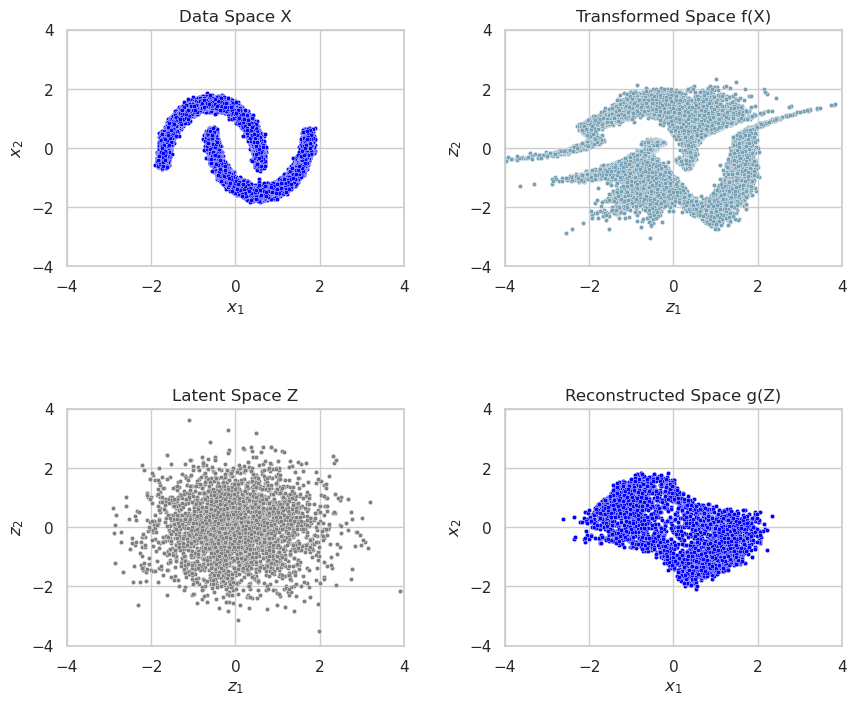

118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - loss: 2.5171
Epoch 2/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 2.0430
Epoch 3/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 1.7256
Epoch 4/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.5587
Epoch 5/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.4657
Epoch 6/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.4247
Epoch 7/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3650
Epoch 8/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.3003
Epoch 9/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.2617
Epoch 10/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.2127
Epoch 11/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2134

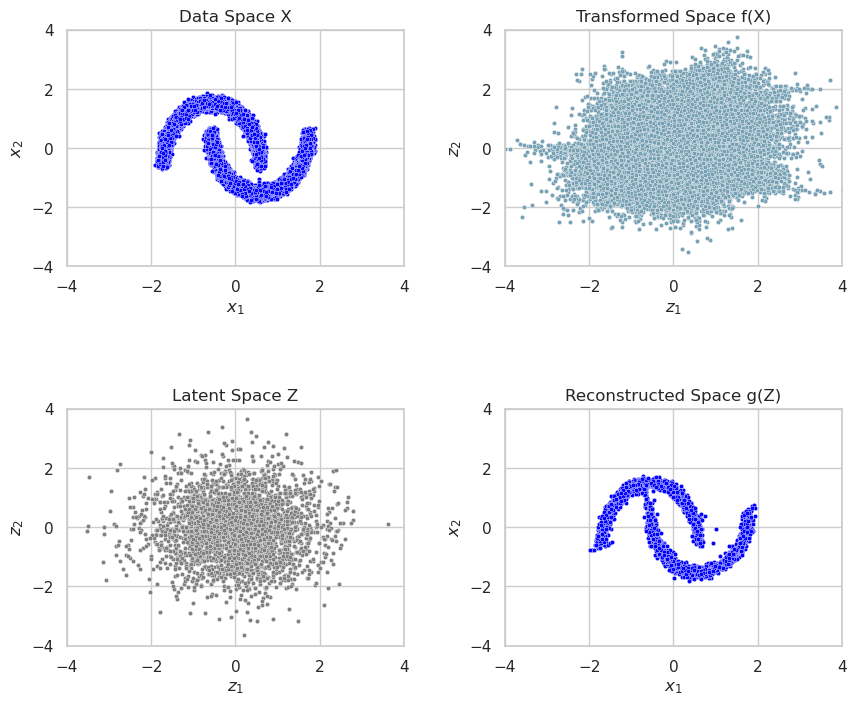

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.2130
Epoch 12/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.2051
Epoch 13/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2102
Epoch 14/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.1978
Epoch 15/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.1962
Epoch 16/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1952
Epoch 17/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 1.1963
Epoch 18/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.1803
Epoch 19/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1981
Epoch 20/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1826
Epoch 21/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1758

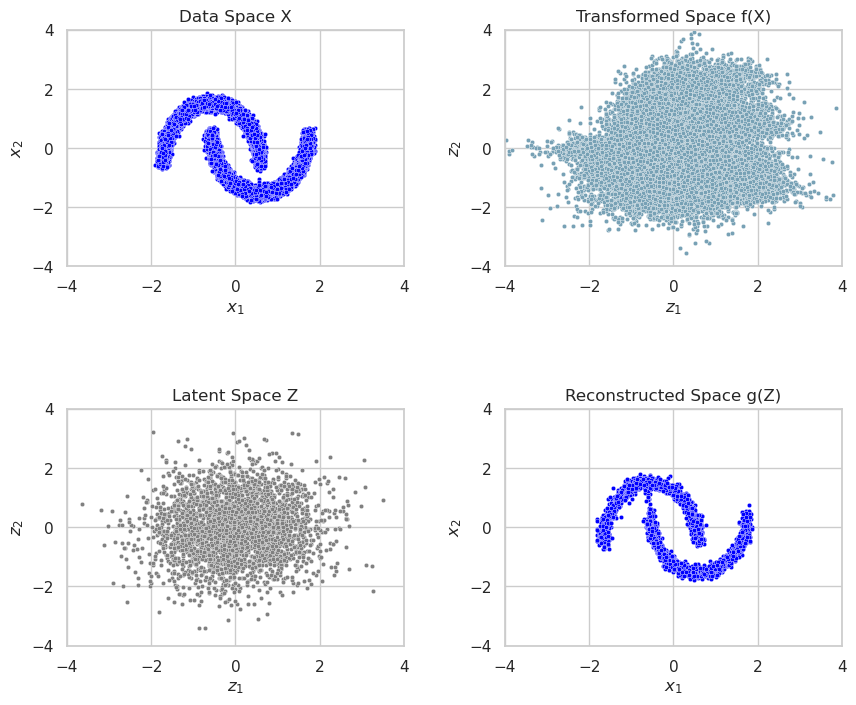

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 1.1759
Epoch 22/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.2023
Epoch 23/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1918
Epoch 24/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1970
Epoch 25/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1918
Epoch 26/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1851
Epoch 27/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1784
Epoch 28/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.1847
Epoch 29/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1818
Epoch 30/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1911
Epoch 31/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1814

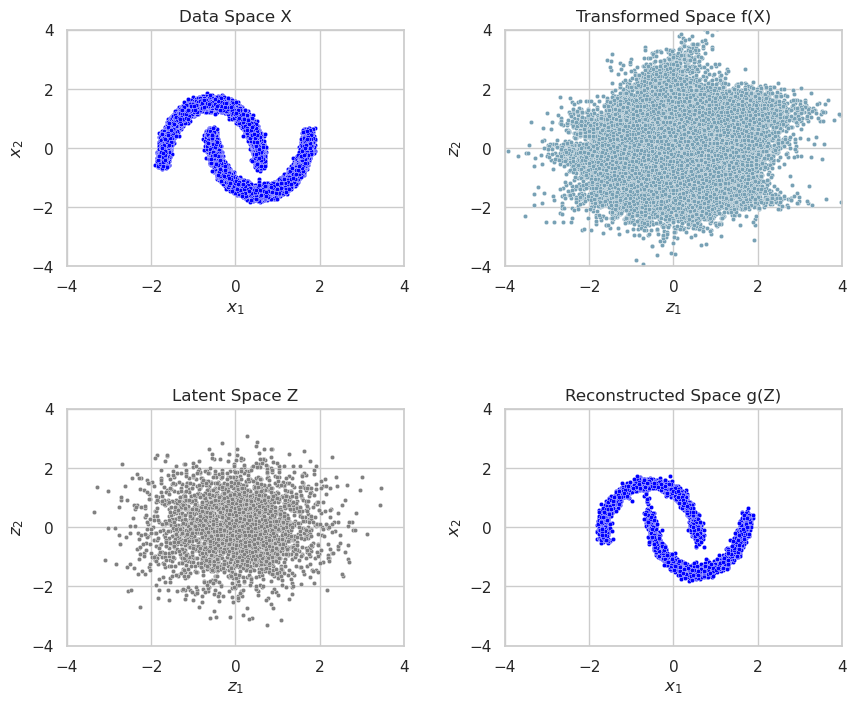

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1815
Epoch 32/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 1.1870
Epoch 33/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1870
Epoch 34/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.1808
Epoch 35/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.1819
Epoch 36/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1734
Epoch 37/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1700
Epoch 38/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1685
Epoch 39/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 1.1861
Epoch 40/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.1837
Epoch 41/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2079

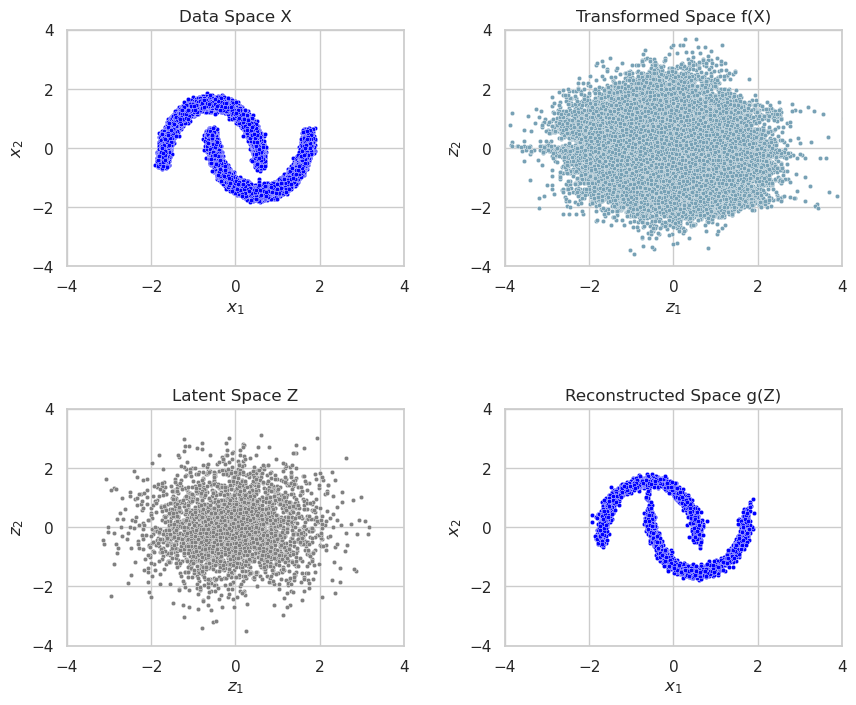

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.2079
Epoch 42/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1887
Epoch 43/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.1746
Epoch 44/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1716
Epoch 45/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1650
Epoch 46/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1871
Epoch 47/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1793
Epoch 48/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1739
Epoch 49/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1730
Epoch 50/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1692
Epoch 51/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1700

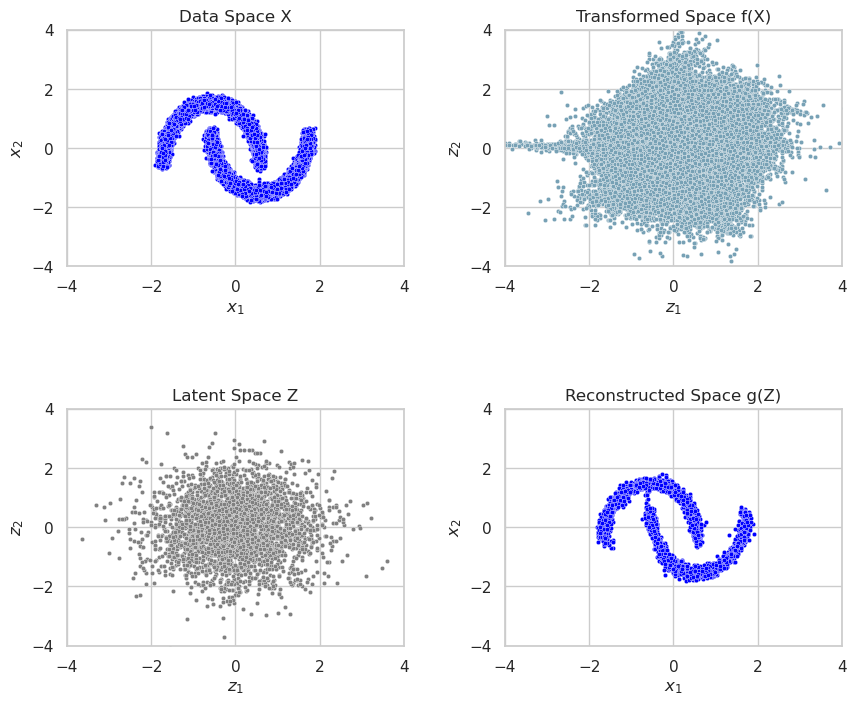

118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 1.1700
Epoch 52/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1752
Epoch 53/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1800
Epoch 54/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1665
Epoch 55/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.1897
Epoch 56/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1736
Epoch 57/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1652
Epoch 58/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 1.1615
Epoch 59/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 1.1670
Epoch 60/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.1754
Epoch 61/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1756

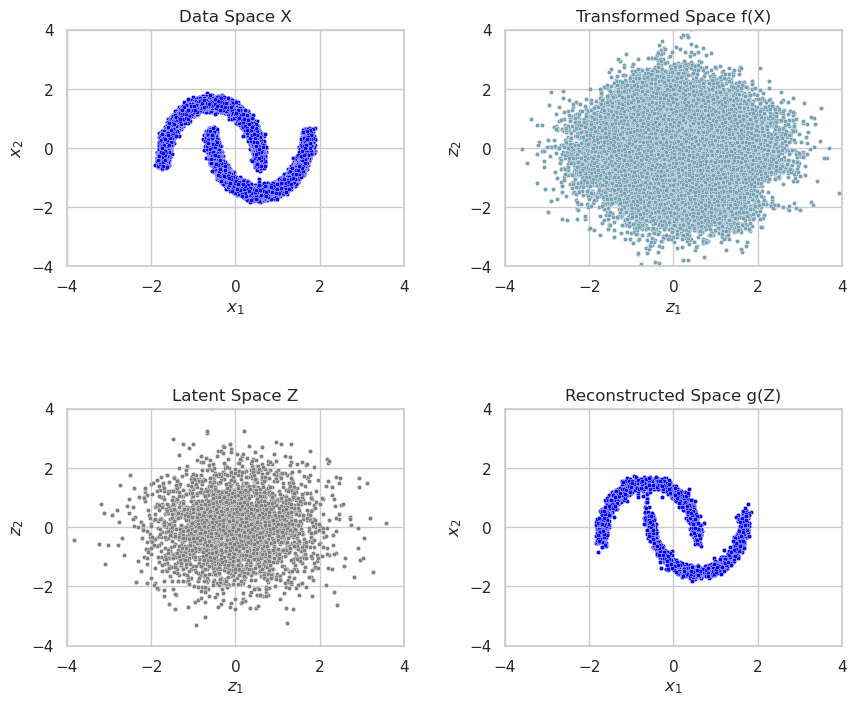

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 1.1755
Epoch 62/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1852
Epoch 63/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1807
Epoch 64/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1793
Epoch 65/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1711
Epoch 66/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.1731
Epoch 67/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1748
Epoch 68/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1603
Epoch 69/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1780
Epoch 70/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1654
Epoch 71/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1710

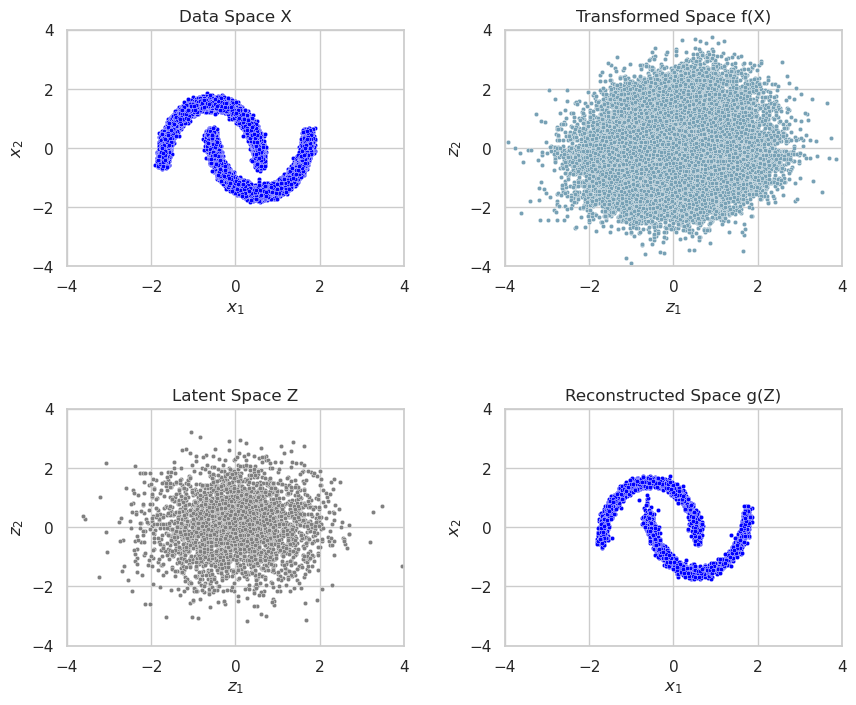

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1710
Epoch 72/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 1.1640
Epoch 73/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1624
Epoch 74/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.1736
Epoch 75/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1623
Epoch 76/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.1697
Epoch 77/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1762
Epoch 78/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1610
Epoch 79/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1684
Epoch 80/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1926
Epoch 81/300
 28/118 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.1719

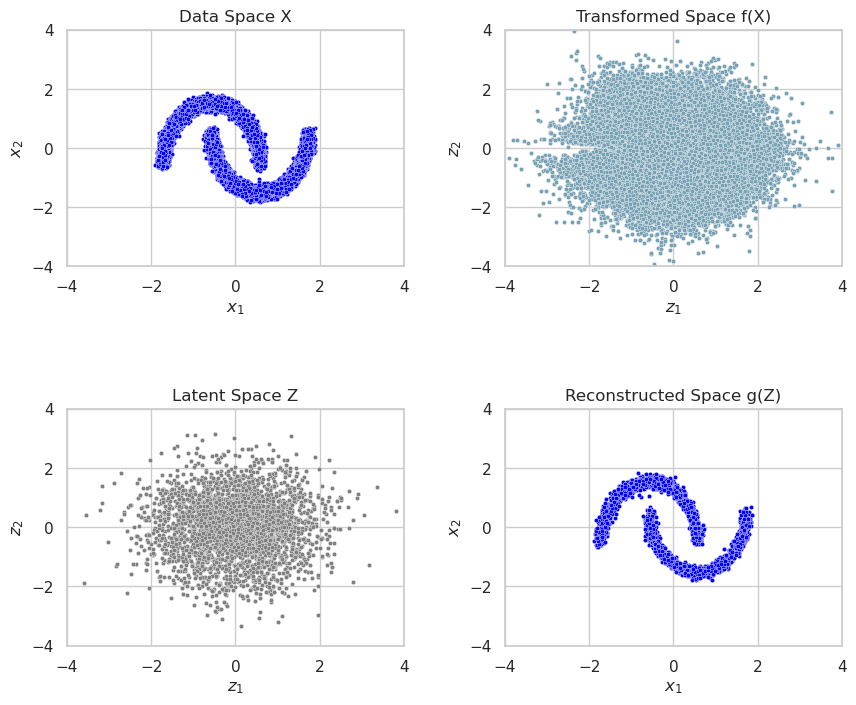

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1728
Epoch 82/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1571
Epoch 83/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.1648
Epoch 84/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.1705
Epoch 85/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.1716
Epoch 86/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1710
Epoch 87/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1683
Epoch 88/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.1803
Epoch 89/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.1601
Epoch 90/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1627
Epoch 91/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1789

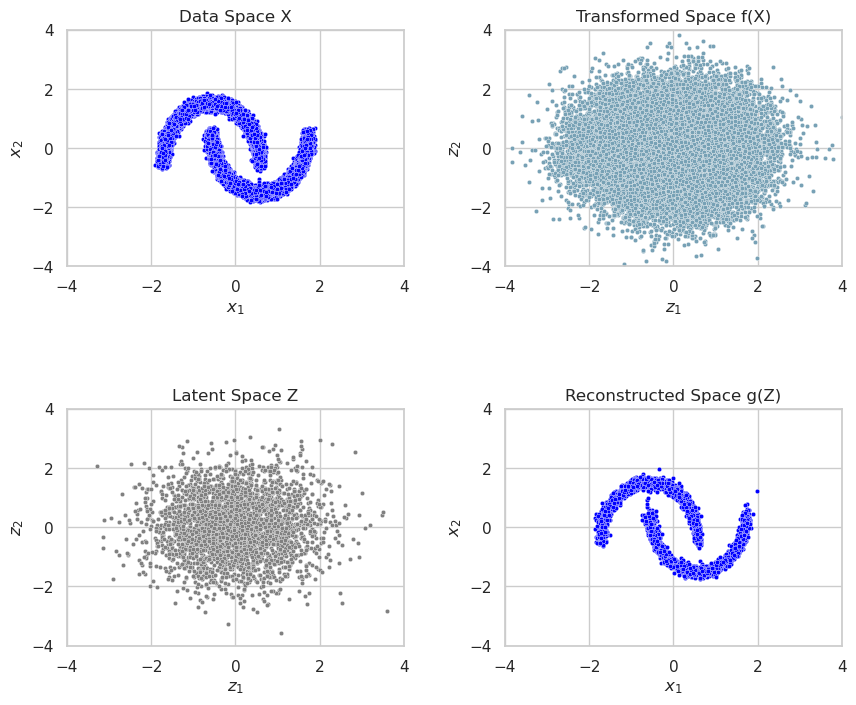

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 1.1786
Epoch 92/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1646
Epoch 93/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.1634
Epoch 94/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.1657
Epoch 95/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1709
Epoch 96/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 1.1602
Epoch 97/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1772
Epoch 98/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1642
Epoch 99/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1545
Epoch 100/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1689
Epoch 101/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1630

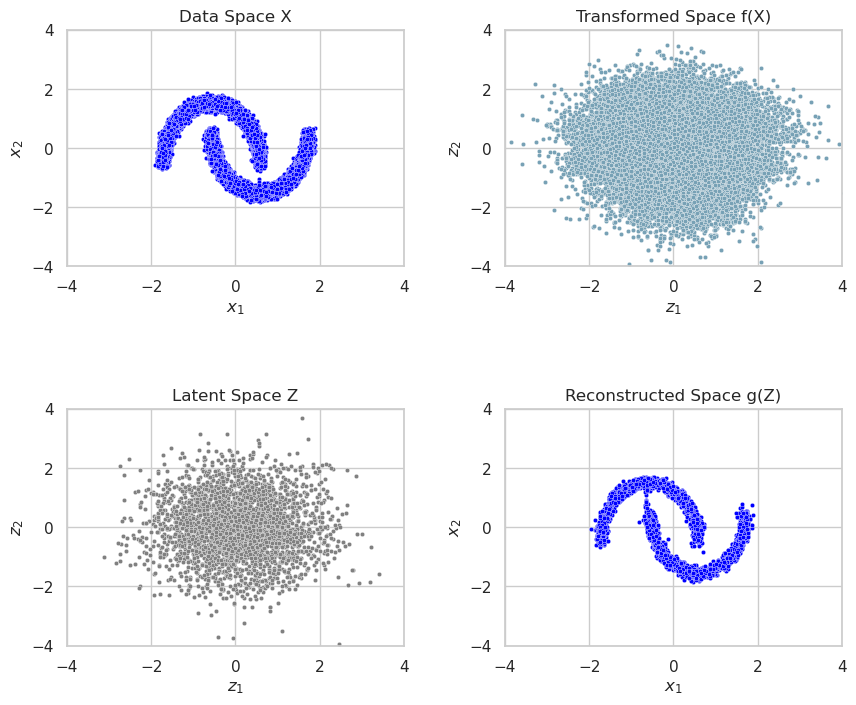

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 1.1631
Epoch 102/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1710
Epoch 103/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1655
Epoch 104/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 1.1657
Epoch 105/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.1664
Epoch 106/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1723
Epoch 107/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1583
Epoch 108/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.1608
Epoch 109/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1644
Epoch 110/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1640
Epoch 111/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1596

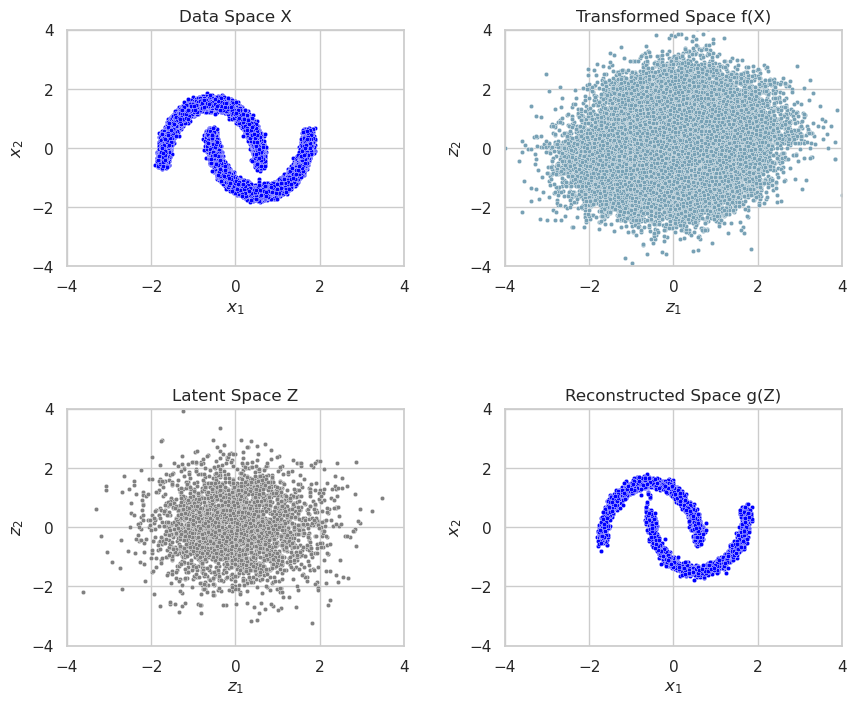

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 1.1596
Epoch 112/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1723
Epoch 113/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.1635
Epoch 114/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1688
Epoch 115/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1669
Epoch 116/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1636
Epoch 117/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.2515
Epoch 118/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.1666
Epoch 119/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1672
Epoch 120/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1570
Epoch 121/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1651

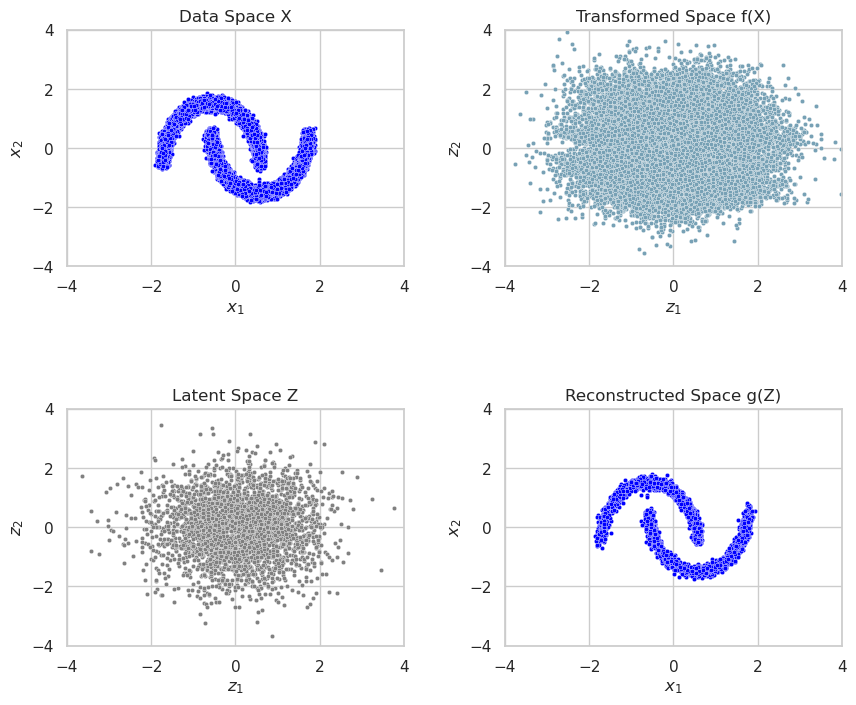

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1651
Epoch 122/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1571
Epoch 123/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1641
Epoch 124/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1556
Epoch 125/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1653
Epoch 126/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1658
Epoch 127/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1643
Epoch 128/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 1.1718
Epoch 129/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1791
Epoch 130/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1704
Epoch 131/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1521

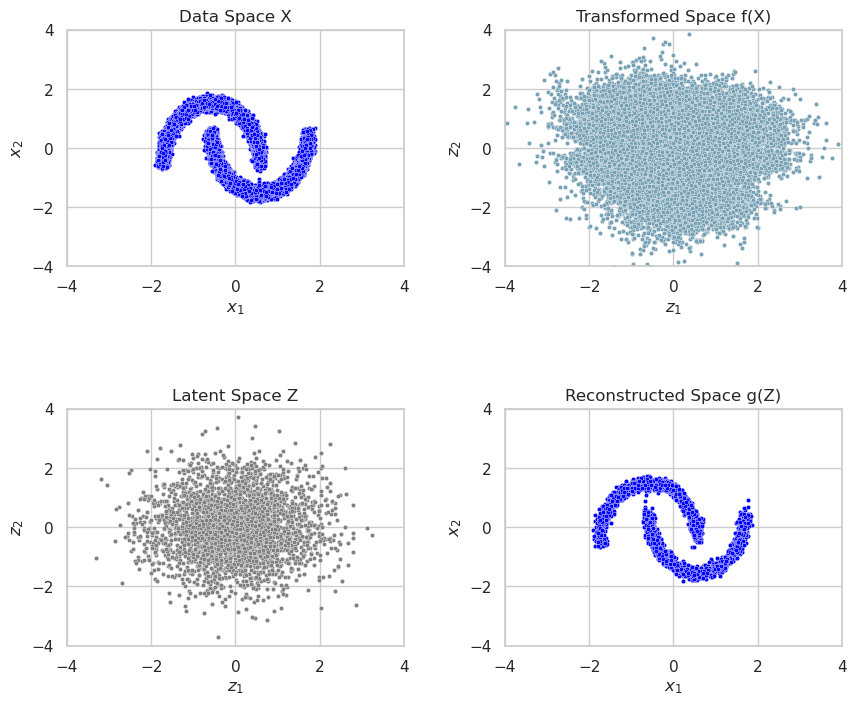

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 1.1522
Epoch 132/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.1767
Epoch 133/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1660
Epoch 134/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1616
Epoch 135/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1703
Epoch 136/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1653
Epoch 137/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.1735
Epoch 138/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1669
Epoch 139/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1576
Epoch 140/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.1604
Epoch 141/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1692

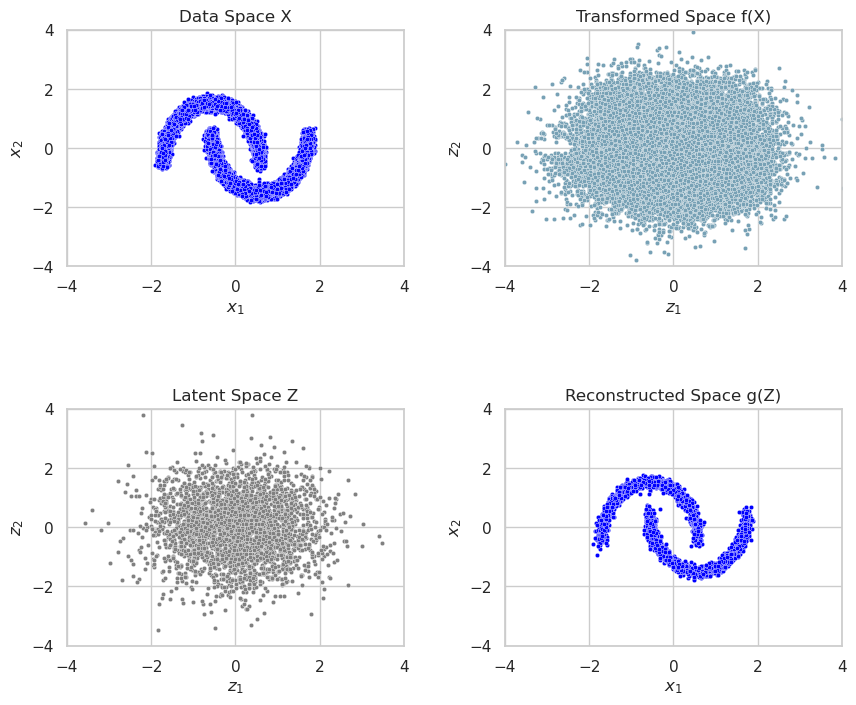

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.1691
Epoch 142/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1604
Epoch 143/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1657
Epoch 144/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1667
Epoch 145/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1545
Epoch 146/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.1605
Epoch 147/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1592
Epoch 148/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1668
Epoch 149/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1556
Epoch 150/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1633
Epoch 151/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1532

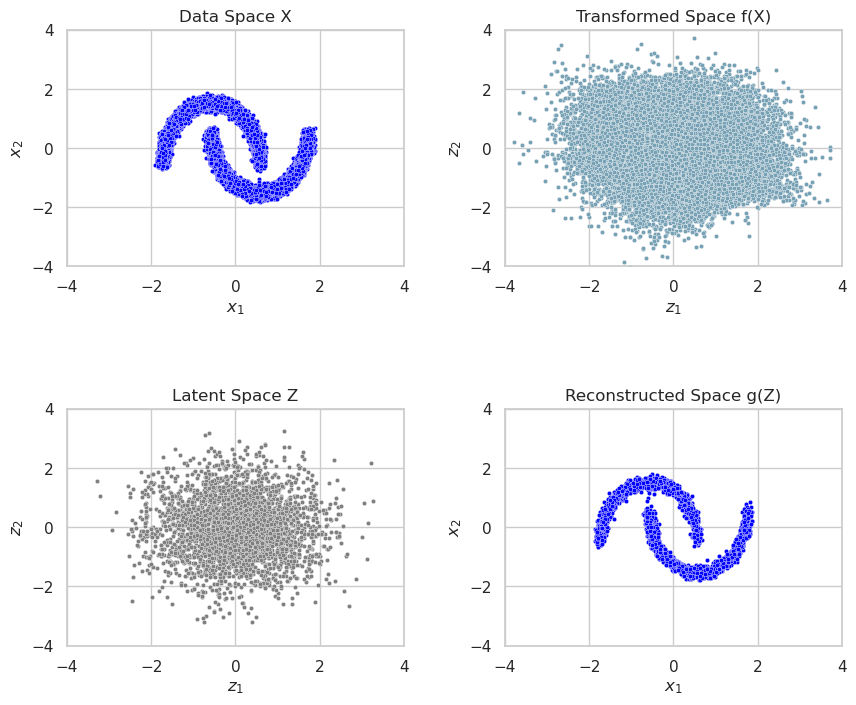

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1535
Epoch 152/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1590
Epoch 153/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.1635
Epoch 154/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1828
Epoch 155/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 1.1937
Epoch 156/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1678
Epoch 157/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.1720
Epoch 158/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1585
Epoch 159/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.1578
Epoch 160/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.1651
Epoch 161/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1643

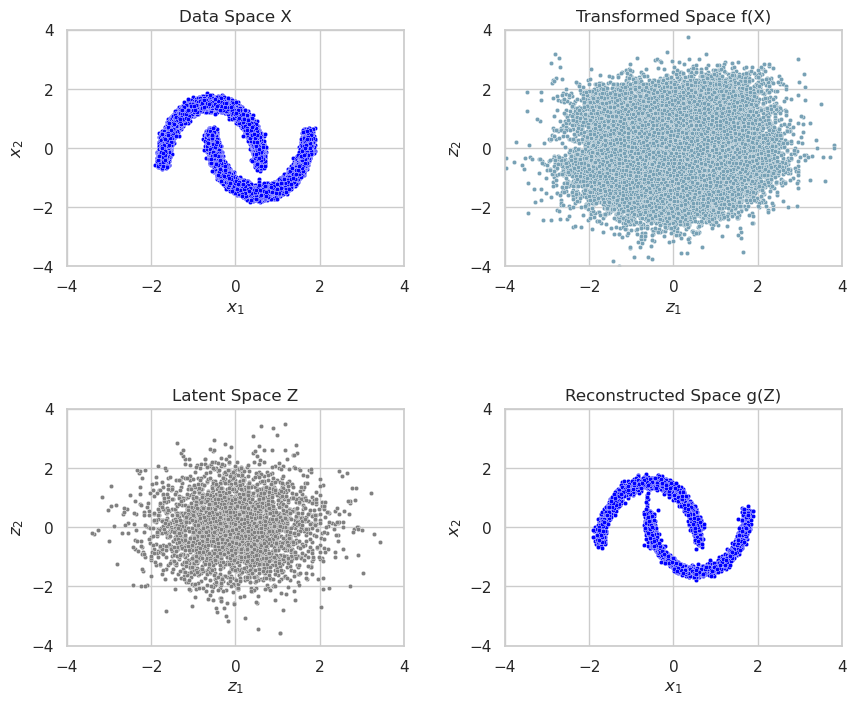

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 1.1643
Epoch 162/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1598
Epoch 163/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1677
Epoch 164/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1576
Epoch 165/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.1697
Epoch 166/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1640
Epoch 167/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1551
Epoch 168/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 1.1534
Epoch 169/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1579
Epoch 170/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1578
Epoch 171/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1560

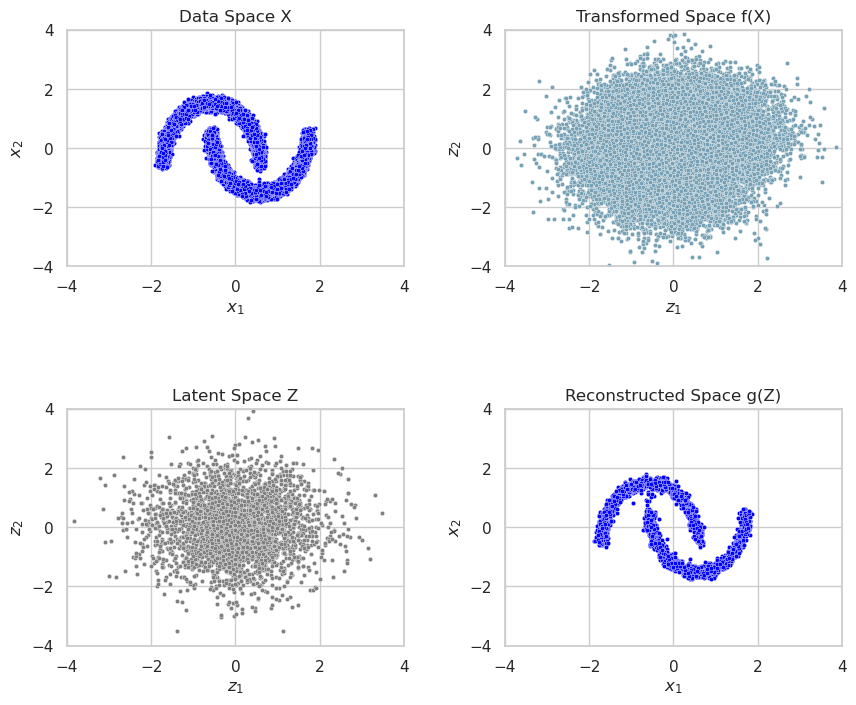

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 1.1560
Epoch 172/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1565
Epoch 173/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1577
Epoch 174/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1570
Epoch 175/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1628
Epoch 176/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1659
Epoch 177/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1588
Epoch 178/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 1.1595
Epoch 179/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1761
Epoch 180/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1746
Epoch 181/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1511

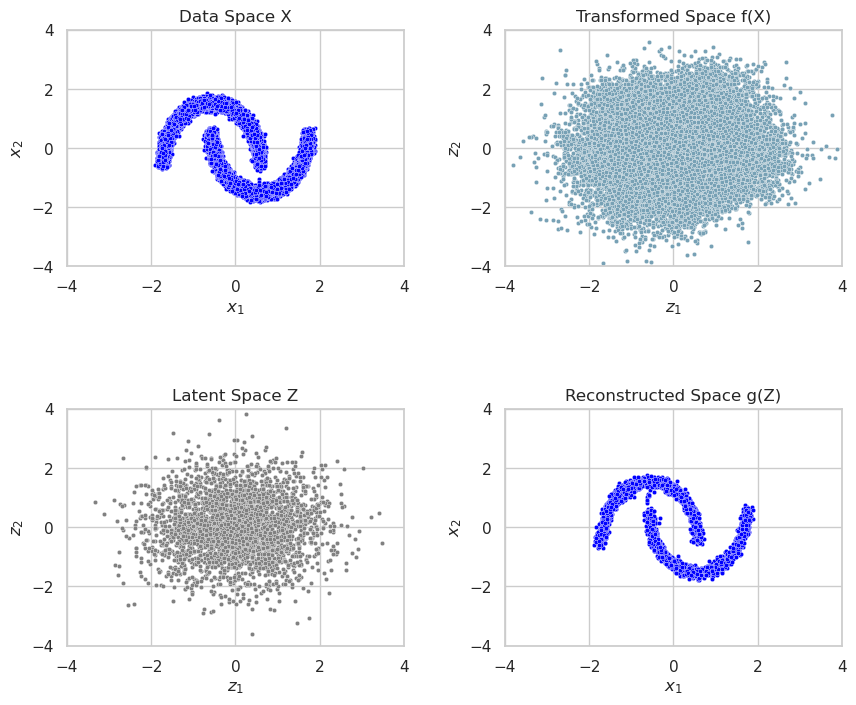

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1512
Epoch 182/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1531
Epoch 183/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1516
Epoch 184/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1730
Epoch 185/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 1.1648
Epoch 186/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.1628
Epoch 187/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 1.1544
Epoch 188/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1545
Epoch 189/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1665
Epoch 190/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.1612
Epoch 191/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1533

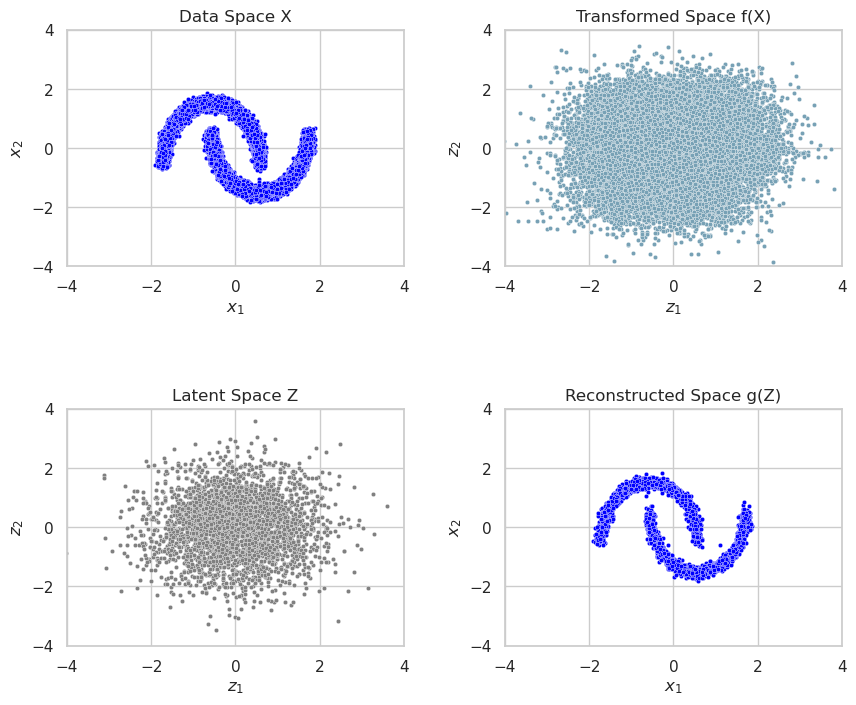

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 1.1534
Epoch 192/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1549
Epoch 193/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1532
Epoch 194/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1647
Epoch 195/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1632
Epoch 196/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1765
Epoch 197/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.1747
Epoch 198/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1556
Epoch 199/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1582
Epoch 200/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.1528
Epoch 201/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.1523

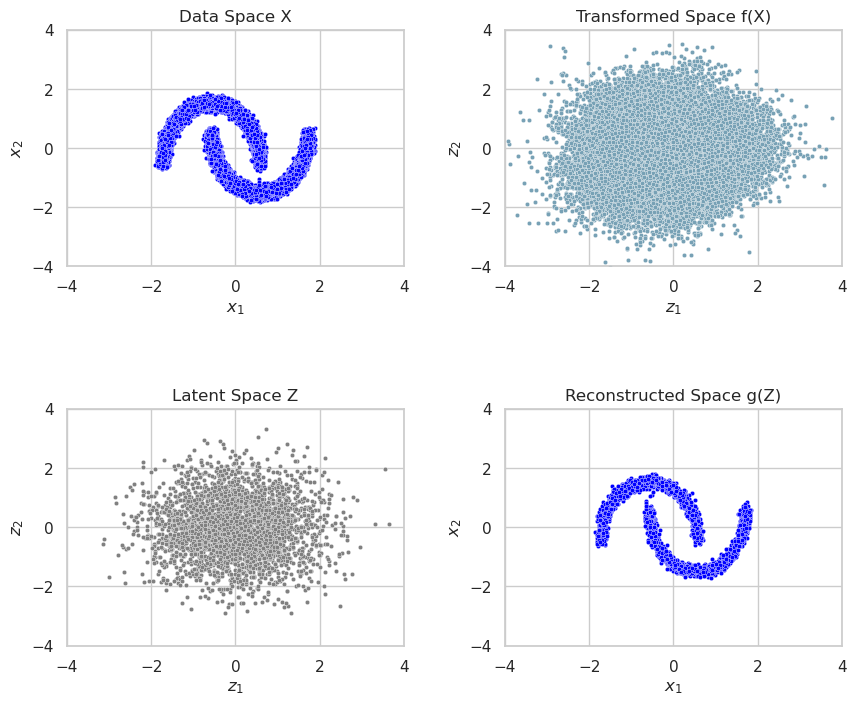

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 1.1523
Epoch 202/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 1.1603
Epoch 203/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1510
Epoch 204/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.1738
Epoch 205/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1561
Epoch 206/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 1.1636
Epoch 207/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1595
Epoch 208/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.1588
Epoch 209/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1526
Epoch 210/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1627
Epoch 211/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1531

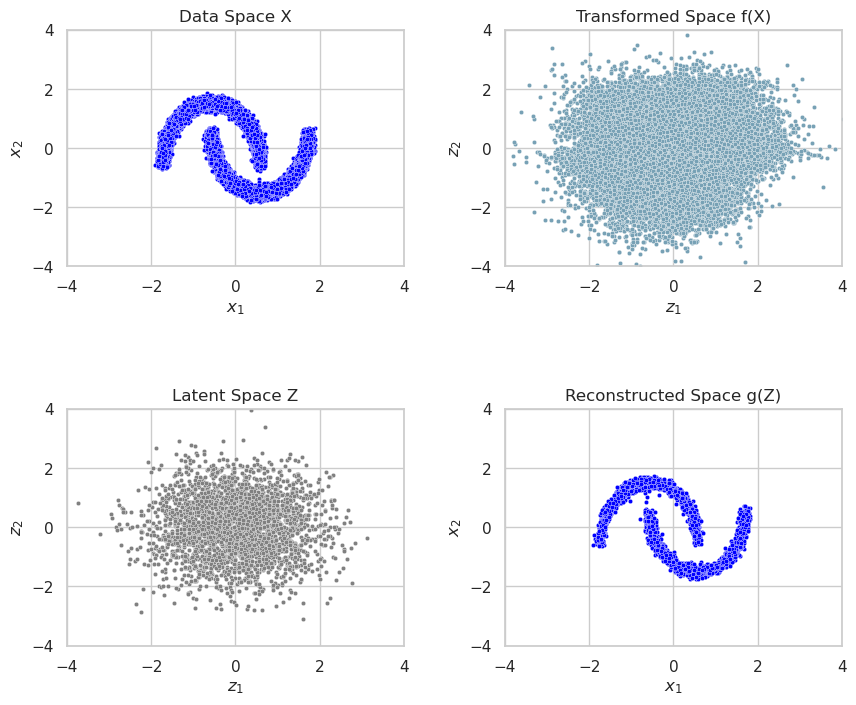

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1531
Epoch 212/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1675
Epoch 213/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1510
Epoch 214/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1583
Epoch 215/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.1566
Epoch 216/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1496
Epoch 217/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1599
Epoch 218/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1679
Epoch 219/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1665
Epoch 220/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1595
Epoch 221/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1564

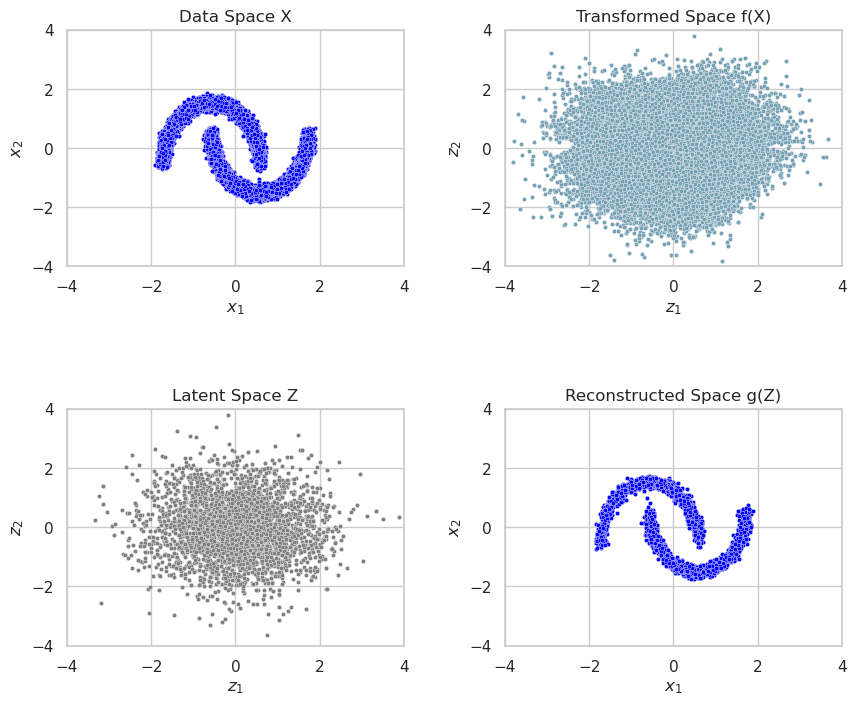

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 1.1564
Epoch 222/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1600
Epoch 223/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1563
Epoch 224/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1659
Epoch 225/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1573
Epoch 226/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1599
Epoch 227/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1572
Epoch 228/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1632
Epoch 229/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1630
Epoch 230/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 1.1597
Epoch 231/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1521

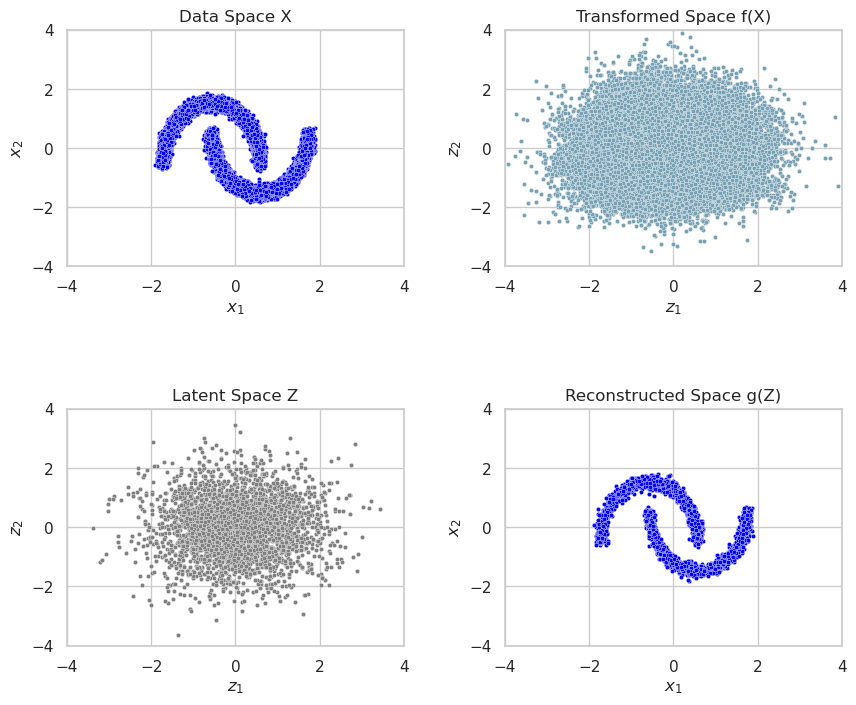

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1522
Epoch 232/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1648
Epoch 233/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1594
Epoch 234/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1541
Epoch 235/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1561
Epoch 236/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1681
Epoch 237/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1572
Epoch 238/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1523
Epoch 239/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1595
Epoch 240/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.1565
Epoch 241/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.1547

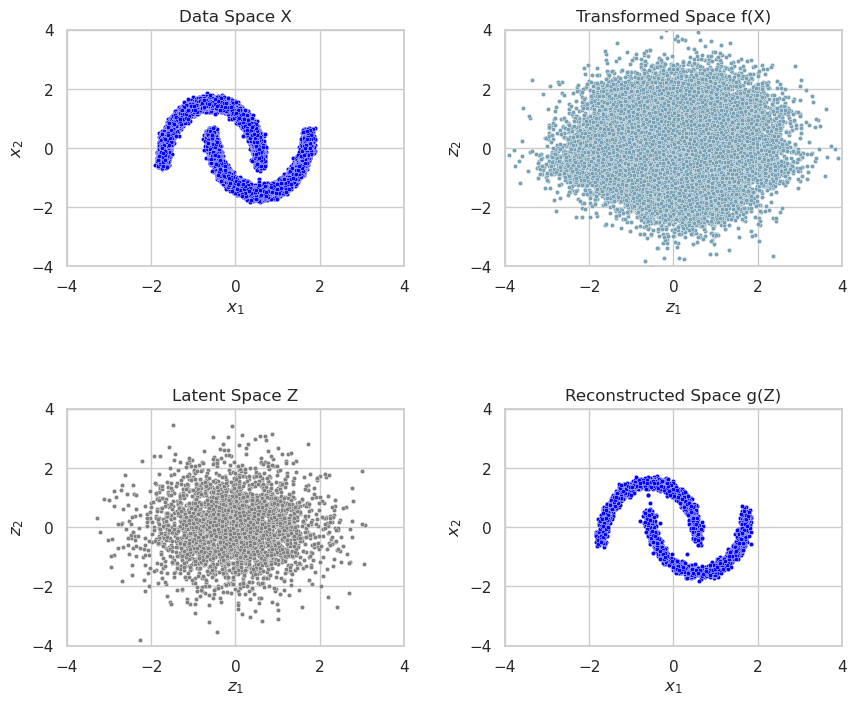

118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 1.1547
Epoch 242/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1581
Epoch 243/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1541
Epoch 244/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1685
Epoch 245/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1632
Epoch 246/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1530
Epoch 247/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1606
Epoch 248/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1542
Epoch 249/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.1608
Epoch 250/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 1.1534
Epoch 251/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1640

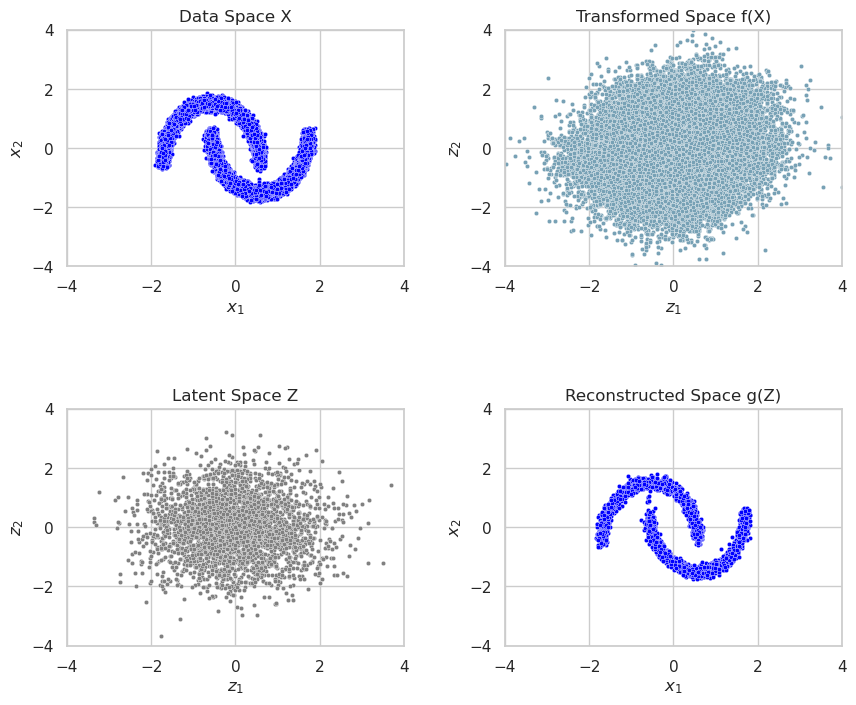

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 1.1638
Epoch 252/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1563
Epoch 253/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.1643
Epoch 254/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.1542
Epoch 255/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1500
Epoch 256/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1641
Epoch 257/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1518
Epoch 258/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1560
Epoch 259/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1509
Epoch 260/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1588
Epoch 261/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1541

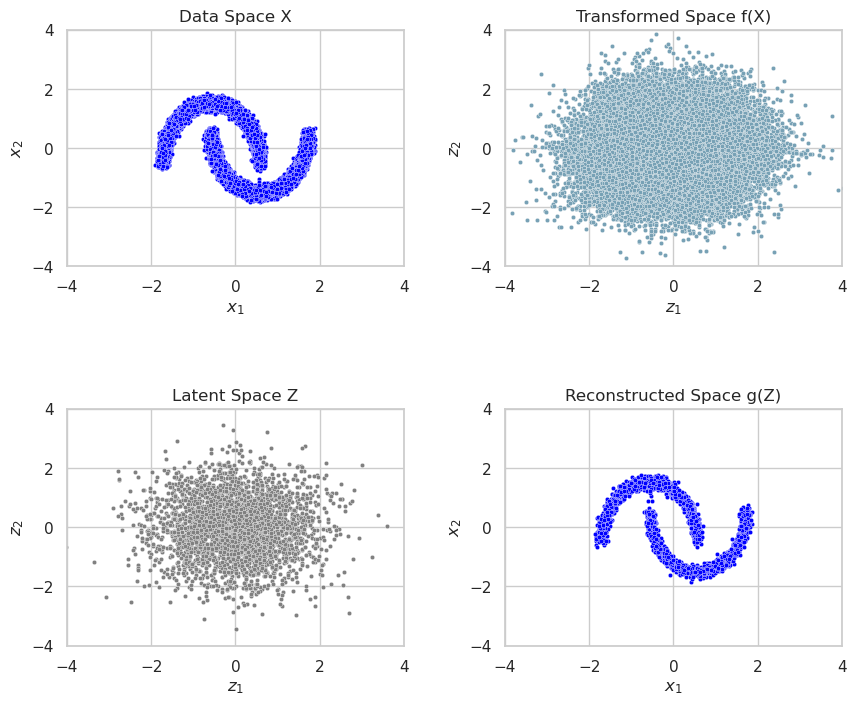

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1541
Epoch 262/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.1551
Epoch 263/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1494
Epoch 264/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1582
Epoch 265/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 1.1609
Epoch 266/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1511
Epoch 267/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 1.1531
Epoch 268/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 1.1533
Epoch 269/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.1545
Epoch 270/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1557
Epoch 271/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1588

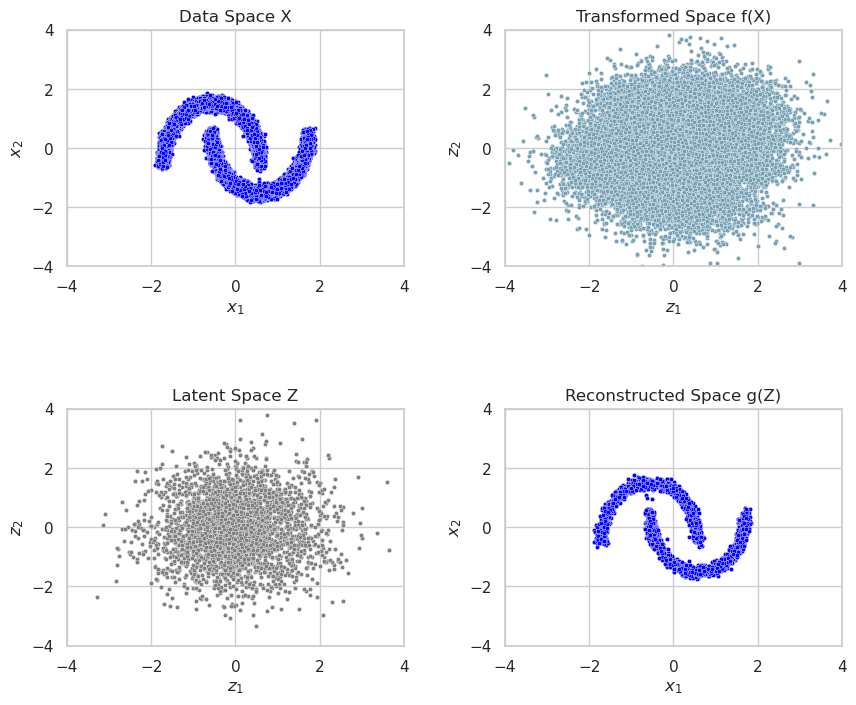

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 1.1587
Epoch 272/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1600
Epoch 273/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1534
Epoch 274/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.1500
Epoch 275/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1523
Epoch 276/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1592
Epoch 277/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.1596
Epoch 278/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1505
Epoch 279/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1493
Epoch 280/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1473
Epoch 281/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1515

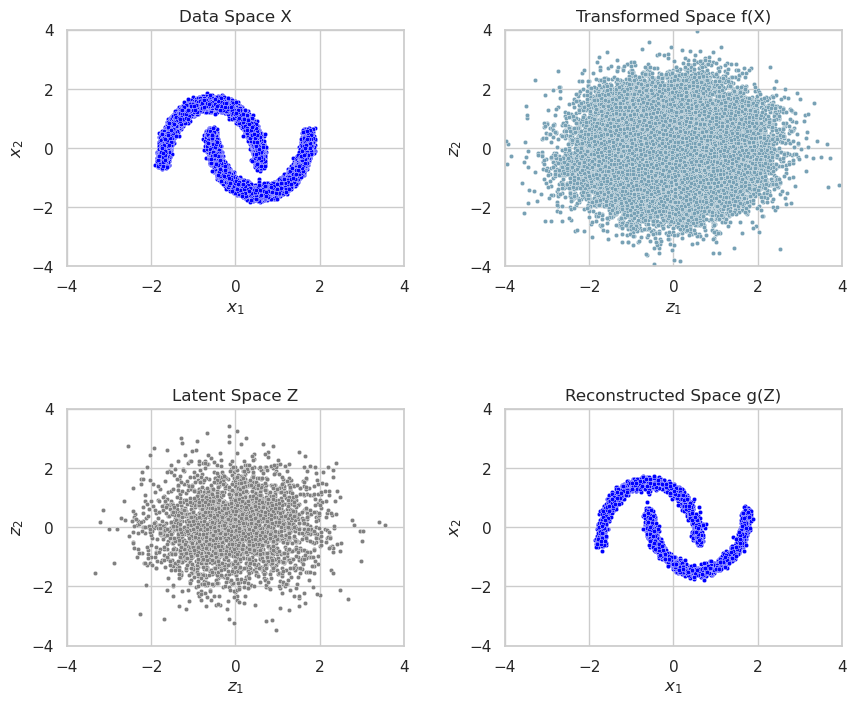

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1515
Epoch 282/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1529
Epoch 283/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.1527
Epoch 284/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1459
Epoch 285/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1536
Epoch 286/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.1669
Epoch 287/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1530
Epoch 288/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1525
Epoch 289/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.1467
Epoch 290/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1544
Epoch 291/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1523

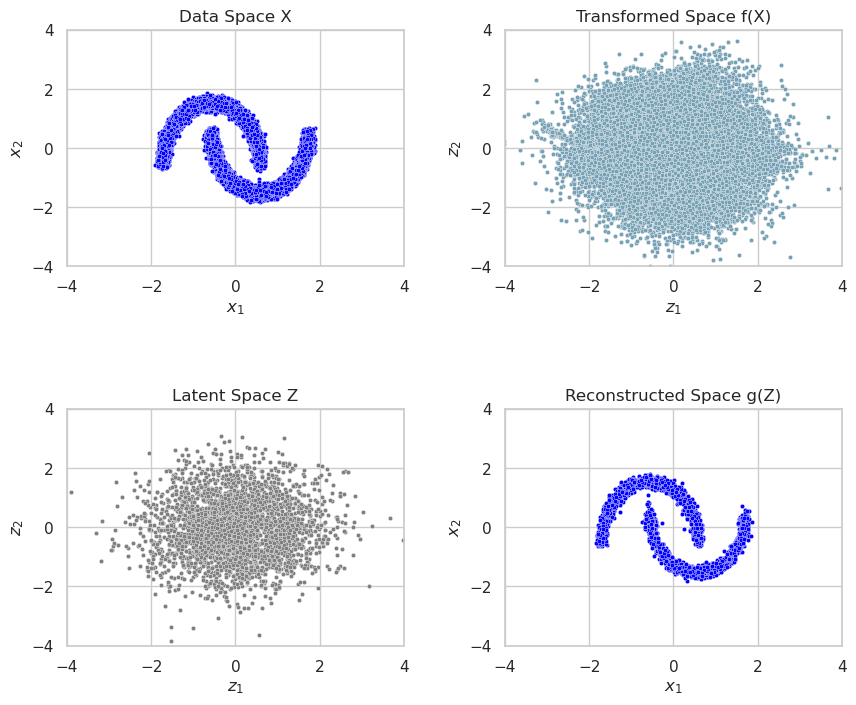

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 1.1524
Epoch 292/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 1.1591
Epoch 293/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1537
Epoch 294/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1580
Epoch 295/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1574
Epoch 296/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1573
Epoch 297/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1560
Epoch 298/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1471
Epoch 299/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.1555
Epoch 300/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.1455
CPU times: user 35min 5s, sys: 2min 46s, total: 37min 51s
Wall time: 35min 12s


In [29]:
%%time
model.fit(
    x_norm,
    batch_size=256,
    epochs=300,
    callbacks=[
        tensorboard_callback,
        img_generator_callback
    ]
)

**INTERIM CONCLUSION**

As we can see after 300 epochs our model has been successfully reconstruct data from latent space

The RealNVP paper also shows how it is possible to apply
this technique to images, by using convolutions inside the
coupling layers, rather than densely connected layers. The
GLOW paper extended this idea to remove the necessity for
any hardcoded permutation of the masks. The FFJORD
model introduced the concept of continuous time
normalizing flows, by modeling the transformation process
as an ODE defined by a neural network.

**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Make Moons](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.make_moons.html): Scikit-learn Make Moons Dataset
5. [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803v3.) Real NVP Paper
6. [RealNVP by Brian Keng](https://bjlkeng.io/posts/normalizing-flows-with-real-nvp/): Great article and refernce as different approach on RealNVP
7. [Density estimation using Real NVP](https://ar5iv.labs.arxiv.org/html/1605.08803): Original article by  Laurent Dinh
8. [Tutorial 11: Normalizing Flows for image modeling](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html): Amazing tutorial by Phillip Lippe